In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
url = '/content/drive/MyDrive/4.2/soft computing lab/assignment 2/'

In [18]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [19]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [20]:
TRAIN_PATH = url + 'Train'

In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [21]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [22]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [23]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

16


In [24]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [25]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU() 
      
 
       

        
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)      
 
       
 
      

        
        probas  = self.linear_out(out)
        return probas

In [26]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [28]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0 :        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.290172576904297. Accuracy: 10.002058036633052
Epoch:  2
Iteration: 1000. Loss: 2.305429220199585. Accuracy: 9.63161144268368
Iteration: 1500. Loss: 2.3019614219665527. Accuracy: 9.878575838649928
Epoch:  3
Iteration: 2000. Loss: 2.2994399070739746. Accuracy: 9.837415105988887
Iteration: 2500. Loss: 2.3009982109069824. Accuracy: 9.734513274336283
Epoch:  4
Iteration: 3000. Loss: 2.3066558837890625. Accuracy: 9.878575838649928
Iteration: 3500. Loss: 2.310382127761841. Accuracy: 10.290183165260341
Epoch:  5
Iteration: 4000. Loss: 2.3033883571624756. Accuracy: 9.796254373327844
Iteration: 4500. Loss: 2.302509307861328. Accuracy: 9.878575838649928
Epoch:  6
Iteration: 5000. Loss: 2.3021090030670166. Accuracy: 9.734513274336283
Iteration: 5500. Loss: 2.3036048412323. Accuracy: 9.837415105988887
Epoch:  7
Iteration: 6000. Loss: 2.308711528778076. Accuracy: 9.878575838649928
Iteration: 6500. Loss: 2.303990125656128. Accuracy: 9.878575838649928
Epoch:  8
Iterat

[2.290172576904297, 2.305429220199585, 2.3019614219665527, 2.2994399070739746, 2.3009982109069824, 2.3066558837890625, 2.310382127761841, 2.3033883571624756, 2.302509307861328, 2.3021090030670166, 2.3036048412323, 2.308711528778076, 2.303990125656128, 2.3007378578186035, 2.3046929836273193, 2.304460048675537, 2.2994847297668457, 2.2994391918182373, 2.2970378398895264, 2.307356595993042, 2.3039605617523193, 2.300011396408081, 2.303220748901367, 2.3013672828674316, 2.304790496826172, 2.297792434692383, 2.3038980960845947, 2.304879665374756, 2.3004703521728516, 2.30230975151062, 2.296729564666748]


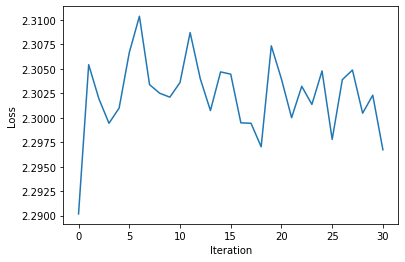

In [29]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4.2/soft computing lab/assignment 2/model_base.pkl')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/4.2/soft computing lab/assignment 2/model_base.pkl'))

## **Changing** **Parameters**

In [30]:
batch_size = 35
num_iters = 80000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.03

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

115


In [31]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:556
Test dataloader:139


In [32]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        
      
 
       

        
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
       
 
       
 
      

        
        probas  = self.linear_out(out)
        return probas

In [33]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [35]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0 :        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.301783561706543. Accuracy: 12.986211154558552
Epoch:  2
Iteration: 1000. Loss: 2.2602291107177734. Accuracy: 12.698086025931262
Epoch:  3
Iteration: 1500. Loss: 2.1743104457855225. Accuracy: 21.568223914385676
Epoch:  4
Iteration: 2000. Loss: 2.2560319900512695. Accuracy: 28.730191397406873
Epoch:  5
Iteration: 2500. Loss: 2.1840996742248535. Accuracy: 24.120189339370242
Epoch:  6
Iteration: 3000. Loss: 2.3771281242370605. Accuracy: 19.777732043630376
Epoch:  7
Iteration: 3500. Loss: 2.0932366847991943. Accuracy: 29.409343486314057
Epoch:  8
Iteration: 4000. Loss: 1.9607391357421875. Accuracy: 30.294299238526445
Epoch:  9
Iteration: 4500. Loss: 1.9551444053649902. Accuracy: 28.215682239143856
Iteration: 5000. Loss: 1.8144567012786865. Accuracy: 26.71331549701585
Epoch:  10
Iteration: 5500. Loss: 1.8661017417907715. Accuracy: 36.46840913768265
Epoch:  11
Iteration: 6000. Loss: 1.8304632902145386. Accuracy: 37.95019551348014
Epoch:  12
Iteration: 6500. L

[2.301783561706543, 2.2602291107177734, 2.1743104457855225, 2.2560319900512695, 2.1840996742248535, 2.3771281242370605, 2.0932366847991943, 1.9607391357421875, 1.9551444053649902, 1.8144567012786865, 1.8661017417907715, 1.8304632902145386, 1.7683817148208618, 1.6813231706619263, 1.8382858037948608, 1.7362194061279297, 1.9302057027816772, 1.573096513748169, 1.7867052555084229, 1.2687467336654663, 1.7074400186538696, 1.5582700967788696, 1.4145617485046387, 1.3962583541870117, 1.3869192600250244, 1.5170583724975586, 1.6903035640716553, 1.4224053621292114, 1.4639277458190918, 1.3182295560836792, 1.311629295349121, 1.3988361358642578, 1.1740736961364746, 1.268982172012329, 1.0230271816253662, 1.671241044998169, 1.0472468137741089, 1.4867725372314453, 1.1318814754486084, 0.8673659563064575, 1.0038235187530518, 0.8890507817268372, 0.9043420553207397, 0.7324411273002625, 0.9773997664451599, 0.6432550549507141, 1.0619136095046997, 1.18246591091156, 0.8366190195083618, 0.7507981061935425, 0.8543

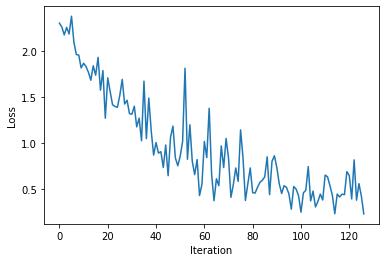

In [36]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [37]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4.2/soft computing lab/assignment 2/model_16.pkl')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/4.2/soft computing lab/assignment 2/model_16.pkl'))